# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.RandomState(0)

In [279]:
region = [75e3, 150e3, 160e3, 250e3]
height = 1500
#coordinates = vd.scatter_points(region, size=1000, random_state=0, extra_coords=height)
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(50, 50), extra_coords=height)]
x, y, z = coordinates
center = [[110e3, 80e3], [200e3, 160e3], [-5e3, -35e3]]
mass = [200 * 4 / 3 * np.pi * np.abs(center[2][0]) ** 3, 400 * 4 / 3 * np.pi * 10e3 ** 3]
base_level = 3
gravity = hm.point_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


gravity += random.normal(loc=0, scale=0.1, size=gravity.size)
xderiv += random.normal(loc=0, scale=0.0005, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.0005, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.0005, size=xderiv.size)

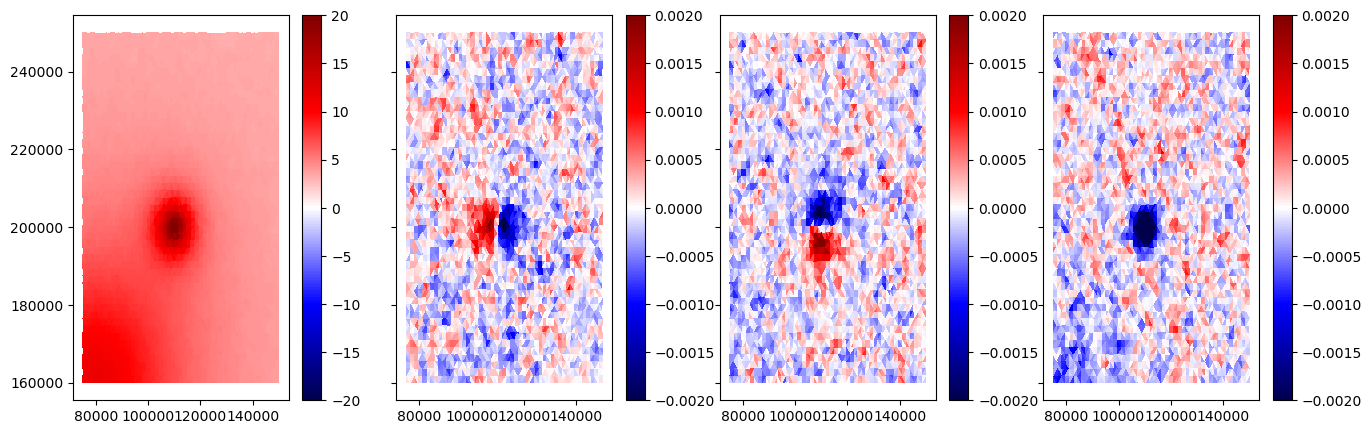

In [280]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
tmp = ax.tripcolor(x, y, gravity, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)

for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp)

## Calculate the matrices involved

In [281]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [282]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [283]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [284]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = B @ Wd_inv @ B.T
    Q_inv = sparse.linalg.inv(Q)
    ATQ = A.T @ Q_inv
    BTQ = B.T @ Q_inv
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    deltap = np.linalg.solve(
        ATQ @ A,
        -ATQ @ (f + Br)
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    return deltap, deltad

In [285]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, maxit=50, tol=1e-5):
    """
    """
    region = vd.get_region(coordinates)
    deast, dnorth = (region[1] - region[0]), (region[3] - region[2])
    area = deast * dnorth
    #area = 1
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
        
    parameters = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        -np.mean(coordinates[2]),
        0,
    ])
    data = np.full_like(data_observed, 1)
    data = np.zeros_like(data_observed)
    data = 0.99 * np.copy(data_observed)
    
    derivative_norm = np.mean([
        np.linalg.norm(xderiv),
        np.linalg.norm(yderiv),
        np.linalg.norm(zderiv),        
    ])   
    derivative_weight = 0.1
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field)),
        np.full_like(field, derivative_weight / derivative_norm),
        np.full_like(field, derivative_weight / derivative_norm),
        np.full_like(field, derivative_weight / derivative_norm),
    ])
    Wd_inv = sparse.diags(1 / wd ** 2, format="csc")
    
    euler_misfit = np.linalg.norm(eulers_equation(*coordinates, data, parameters, structural_index))
    misfit = np.linalg.norm((data_observed - data) * wd)
    print("Initial state | Euler misfit: {:.3f} | data misfit: {:.3f}".format(euler_misfit, misfit))
    
    for i in range(maxit):
        deltap, deltad = gauss_newton_step(
            parameters,
            data, 
            coordinates, 
            data_observed, 
            Wd_inv, 
            structural_index,
        )
        parameters += deltap
        data += deltad
        new_misfit = np.linalg.norm((data_observed - data) * wd)
        misfit_change = np.abs(misfit - new_misfit) / misfit
        misfit = new_misfit
        euler_misfit = np.linalg.norm(
            eulers_equation(*coordinates, data, parameters, structural_index)
        )
        print(" delta p: {} | Euler misfit: {:.10f} | data misfit: {:.5f}".format(deltap, euler_misfit, misfit))
        if misfit_change < tol:
            break
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [286]:
def euler_deconvolution(coordinates, field, xderiv, yderiv, zderiv, structural_index):
    x, y, z = coordinates
    A = np.stack([xderiv, yderiv, zderiv, np.full_like(field, structural_index)], axis=1)
    d = x * xderiv + y * yderiv + z * zderiv + structural_index * field
    parameters = np.linalg.solve(A.T @ A, A.T @ d)
    return parameters

In [289]:
structural_index = 2
p_deconv = euler_deconvolution(coordinates, gravity, xderiv, yderiv, zderiv, structural_index)
p, h, dx, dy, dz = euler_inversion(coordinates, gravity, xderiv, yderiv, zderiv, structural_index)
print()
print("         True:", " ".join("{:.1f}".format(i[0]) for i in center), "{:.1f}".format(base_level))
print("    Inversion:", " ".join("{:.1f}".format(i) for i in p))
print("Devoncolution:", " ".join("{:.1f}".format(i) for i in p_deconv))
print()

Initial state | Euler misfit: 1017.899 | data misfit: 0.010
 delta p: [-1478.65448438 -3363.44627973 -2676.26780329     4.91508758] | Euler misfit: 72.2263318263 | data misfit: 0.09587
 delta p: [-5.04298802e+01 -2.27120408e+02 -7.41084546e+02 -8.34128644e-02] | Euler misfit: 2.5759586606 | data misfit: 0.09229
 delta p: [-4.64170921e+01 -3.39932794e+02 -4.64538407e+02 -9.05860538e-02] | Euler misfit: 0.5501994683 | data misfit: 0.09188
 delta p: [ 3.33570077e+01 -6.81990255e+01 -1.73124180e+02 -1.78767169e-02] | Euler misfit: 0.0969668587 | data misfit: 0.09180
 delta p: [ 1.46173990e+01 -1.00287596e+02 -1.13021723e+02 -1.71089024e-02] | Euler misfit: 0.0345994450 | data misfit: 0.09178
 delta p: [ 2.78028577e+01 -1.67798186e+01 -4.79843582e+01 -4.50979469e-03] | Euler misfit: 0.0076216466 | data misfit: 0.09177
 delta p: [ 1.38391884e+01 -3.11098835e+01 -3.12398930e+01 -4.55870053e-03] | Euler misfit: 0.0030243701 | data misfit: 0.09177
 delta p: [ 1.47885542e+01 -4.26131044e+00 -1.4

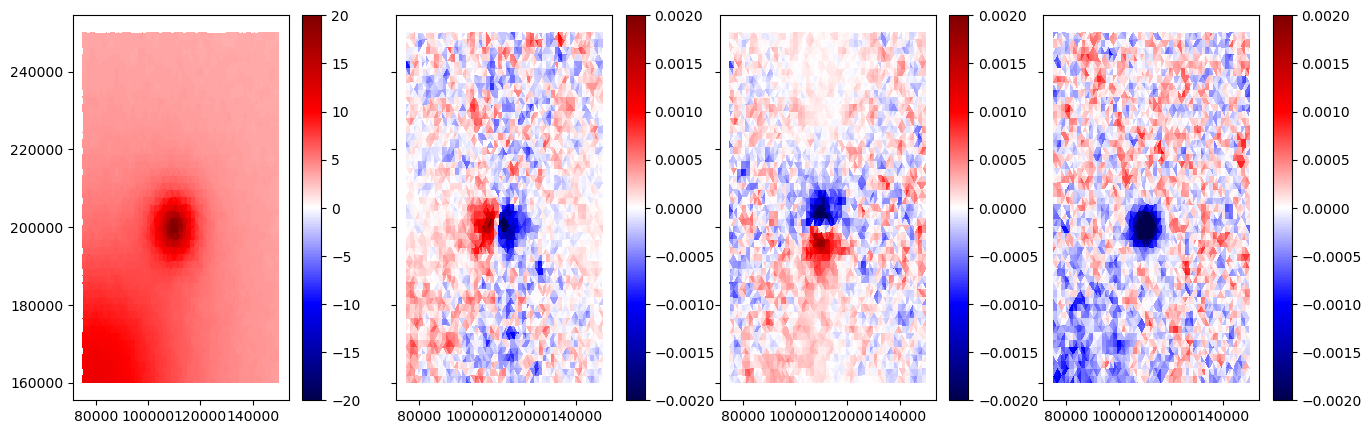

In [290]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, h, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp)

In [147]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=3,
)
print()
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))
print()

Data weights: [0.00519625 0.00519625 0.00519625 ... 0.36022692 0.36022692 0.36022692]
Parameter weights: [1.48148148e-10 1.48148148e-10 1.48148148e-10 5.19624634e-03]
Initial state | Euler misfit: 879.874 | data misfit: 19.245
 delta p: [-2.11632927e+03 -4.93086761e+03 -5.25381922e+03  3.99599784e+00] | Euler misfit: 106.4112157585 | data misfit: 0.010
 delta p: [ 4.65827320e+02  1.73151399e+03 -3.82132645e+02 -3.81341904e-01] | Euler misfit: 12.0616172609 | data misfit: 0.009
 delta p: [-5.51905021e+02 -1.18973669e+03 -1.04035550e+03 -7.08742692e-02] | Euler misfit: 3.1251386496 | data misfit: 0.009
 delta p: [ 9.12644629e+01  7.85859808e+02 -2.60680251e+02 -1.73871157e-02] | Euler misfit: 0.8345777091 | data misfit: 0.009
 delta p: [-1.85087954e+02 -5.22537045e+02 -2.42671500e+02 -2.17279012e-02] | Euler misfit: 0.3983049640 | data misfit: 0.009
 delta p: [ 1.73724197e-01  3.86991721e+02 -9.43133903e+01 -5.31660985e-03] | Euler misfit: 0.1720930285 | data misfit: 0.009
 delta p: [-5.

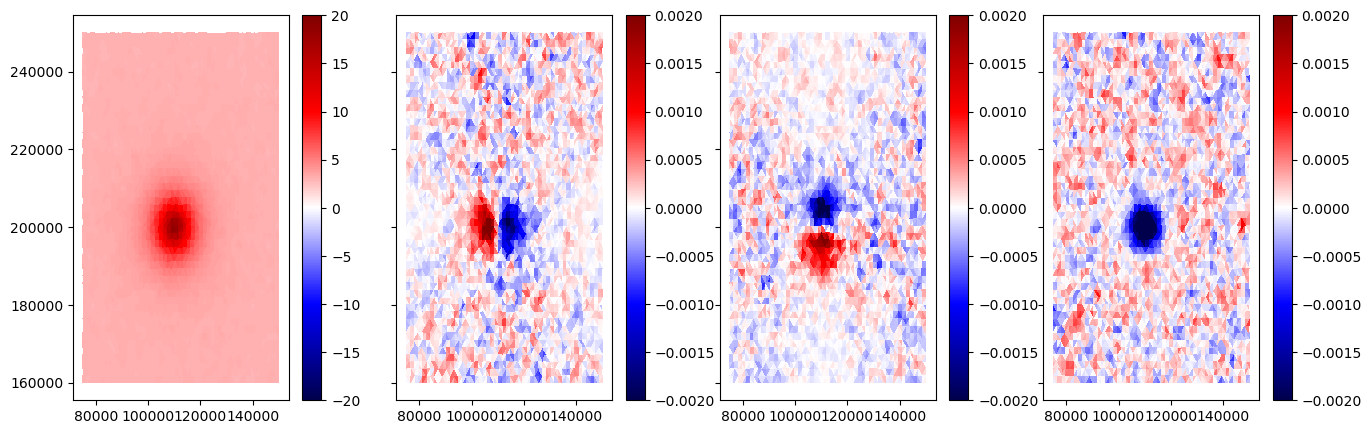

In [148]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, h, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp)

In [149]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=1,
)
print()
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))
print()

Data weights: [0.00519625 0.00519625 0.00519625 ... 0.36022692 0.36022692 0.36022692]
Parameter weights: [1.48148148e-10 1.48148148e-10 1.48148148e-10 5.19624634e-03]
Initial state | Euler misfit: 766.560 | data misfit: 19.245
 delta p: [-1.35753963e+03 -2.89801690e+03  5.65630817e+02  2.07803673e+00] | Euler misfit: 53.1697234795 | data misfit: 0.009
 delta p: [-4.64416886e+02 -3.96162259e+02 -6.42822051e+02 -6.15066329e-01] | Euler misfit: 2.0463319774 | data misfit: 0.009
 delta p: [-1.28644486e+02 -2.97701592e+02  8.30480338e+01 -2.27855740e-02] | Euler misfit: 0.2083660364 | data misfit: 0.009
 delta p: [-1.55179411e+02 -1.30860441e+02 -5.53038416e+01 -7.40371965e-02] | Euler misfit: 0.0784417289 | data misfit: 0.009
 delta p: [-5.51679875e+01 -1.14427286e+02  1.69608413e+01 -7.82182841e-03] | Euler misfit: 0.0295926117 | data misfit: 0.009
 delta p: [-5.36014760e+01 -4.91554909e+01 -5.95675384e+00 -1.34989085e-02] | Euler misfit: 0.0104723982 | data misfit: 0.009
 delta p: [-2.18

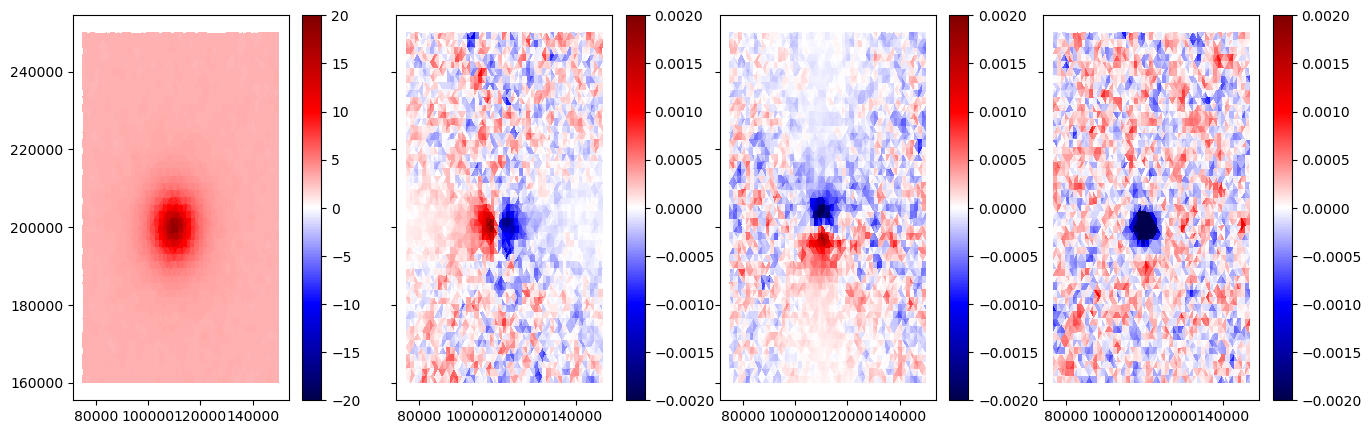

In [150]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
scale = 0.002
cmap = "seismic"
ax = axes[0]
tmp = ax.tripcolor(x, y, h, cmap=cmap, vmin=-20, vmax=20)
plt.colorbar(tmp)
for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.tripcolor(x, y, data, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp)